In [1]:
!pip install google-colab
!pip install -q kaggle

In [2]:
%cd ..
!ls

/
bin			    kaggle		      opt		 sys
boot			    lib			      proc		 tmp
content			    lib32		      python-apt	 tools
cuda-keyring_1.1-1_all.deb  lib64		      python-apt.tar.xz  usr
datalab			    libx32		      root		 var
dev			    media		      run
etc			    mnt			      sbin
home			    NGC-DL-CONTAINER-LICENSE  srv


In [3]:
## Step 1: Organize Data and Create Train/Test Split
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amirbnsl/breast-cancer-padded-interpolated-720p")

Using Colab cache for faster access to the 'breast-cancer-padded-interpolated-720p' dataset.


In [4]:
dataset_path = path
!ls {dataset_path}

0_N  1_PB  2_UDH  3_FEA  4_ADH	5_DCIS	6_IC


# let's get started


In [5]:
import os
import shutil
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split

# Define class folders
class_folders = ['0_N', '1_PB', '2_UDH', '3_FEA', '4_ADH', '5_DCIS', '6_IC']

# Create train and test directories
train_dir = os.path.join('/content', 'train')
test_dir = os.path.join('/content', 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print(f"Dataset path: {dataset_path}")
print(f"Class folders: {class_folders}")
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

Dataset path: /kaggle/input/breast-cancer-padded-interpolated-720p
Class folders: ['0_N', '1_PB', '2_UDH', '3_FEA', '4_ADH', '5_DCIS', '6_IC']
Train directory: /content/train
Test directory: /content/test


In [6]:
# Collect all image paths with their labels
image_data = []

for class_folder in class_folders:
    class_path = os.path.join(dataset_path, class_folder)
    
    if not os.path.exists(class_path):
        print(f"Warning: {class_path} does not exist!")
        continue
    
    # Get all PNG files in the folder
    image_files = [f for f in os.listdir(class_path) if f.endswith('.png')]
    
    for img_file in image_files:
        original_path = os.path.join(class_path, img_file)
        # Create new filename: classname_originalname.png
        new_filename = f"{class_folder}_{img_file}"
        image_data.append({
            'original_path': original_path,
            'new_filename': new_filename,
            'label': class_folder
        })
    
    print(f"Class {class_folder}: {len(image_files)} images")

print(f"\nTotal images collected: {len(image_data)}")

Class 0_N: 324 images
Class 1_PB: 590 images
Class 2_UDH: 374 images
Class 3_FEA: 521 images
Class 4_ADH: 367 images
Class 5_DCIS: 529 images
Class 6_IC: 473 images

Total images collected: 3178


In [7]:
# Extract labels for stratified sampling
labels = [item['label'] for item in image_data]

# Perform stratified split: 90% train, 10% test
train_data, test_data = train_test_split(
    image_data, 
    test_size=0.1, 
    stratify=labels, 
    random_state=42
)

print(f"Train set: {len(train_data)} images")
print(f"Test set: {len(test_data)} images")

# Verify distribution
from collections import Counter
train_labels = [item['label'] for item in train_data]
test_labels = [item['label'] for item in test_data]

print("\nTrain set distribution:")
for label, count in Counter(train_labels).items():
    print(f"  {label}: {count}")

print("\nTest set distribution:")
for label, count in Counter(test_labels).items():
    print(f"  {label}: {count}")

Train set: 2860 images
Test set: 318 images

Train set distribution:
  1_PB: 531
  4_ADH: 330
  3_FEA: 469
  2_UDH: 336
  6_IC: 426
  5_DCIS: 476
  0_N: 292

Test set distribution:
  5_DCIS: 53
  1_PB: 59
  3_FEA: 52
  2_UDH: 38
  6_IC: 47
  4_ADH: 37
  0_N: 32


In [8]:
# Copy files to train directory with new names
print("Copying training images...")
for item in train_data:
    src = item['original_path']
    dst = os.path.join(train_dir, item['new_filename'])
    shutil.copy2(src, dst)

print(f"Copied {len(train_data)} images to {train_dir}")

# Copy files to test directory with new names
print("Copying test images...")
for item in test_data:
    src = item['original_path']
    dst = os.path.join(test_dir, item['new_filename'])
    shutil.copy2(src, dst)

print(f"Copied {len(test_data)} images to {test_dir}")
print("\nStep 1 completed: Train/test split with stratified sampling!")

Copying training images...
Copied 2860 images to /content/train
Copying test images...
Copied 318 images to /content/test

Step 1 completed: Train/test split with stratified sampling!


## Step 2: Calculate Average Non-Black Pixel Value from Training Data

In [9]:
from PIL import Image
import numpy as np
from tqdm import tqdm

# Get all training images
train_images = [f for f in os.listdir(train_dir) if f.endswith('.png')]

print(f"Processing {len(train_images)} training images to calculate average non-black pixel value...")

# Initialize accumulators
total_non_black_sum = np.zeros(3, dtype=np.float64)  # RGB channels
total_non_black_count = 0

# Process each training image
for img_name in tqdm(train_images):
    img_path = os.path.join(train_dir, img_name)
    
    # Load image
    img = Image.open(img_path)
    img_array = np.array(img, dtype=np.float64)
    
    # Find non-black pixels (where not all channels are 0)
    # Black pixel: (0, 0, 0), so we check if sum of channels > 0
    non_black_mask = img_array.sum(axis=2) > 0
    
    # Extract non-black pixels
    non_black_pixels = img_array[non_black_mask]
    
    if len(non_black_pixels) > 0:
        # Sum all non-black pixel values per channel
        total_non_black_sum += non_black_pixels.sum(axis=0)
        total_non_black_count += len(non_black_pixels)

# Calculate average non-black pixel value
average_pixel_value = total_non_black_sum / total_non_black_count

print(f"\nTotal non-black pixels processed: {total_non_black_count}")
print(f"Average non-black pixel value (RGB): {average_pixel_value}")
print(f"  R: {average_pixel_value[0]:.2f}")
print(f"  G: {average_pixel_value[1]:.2f}")
print(f"  B: {average_pixel_value[2]:.2f}")

Processing 2860 training images to calculate average non-black pixel value...


100%|██████████| 2860/2860 [02:40<00:00, 17.81it/s]


Total non-black pixels processed: 1180038395
Average non-black pixel value (RGB): [182.53305314 139.4500102  175.00963714]
  R: 182.53
  G: 139.45
  B: 175.01


In [10]:
# Save the average pixel value to a file
avg_pixel_file = '/content/average_pixel_value.npy'
np.save(avg_pixel_file, average_pixel_value)

print(f"Average pixel value saved to: {avg_pixel_file}")

# Also save as text for easy viewing
with open('/content/average_pixel_value.txt', 'w') as f:
    f.write(f"Average Non-Black Pixel Value (RGB):\n")
    f.write(f"R: {average_pixel_value[0]:.6f}\n")
    f.write(f"G: {average_pixel_value[1]:.6f}\n")
    f.write(f"B: {average_pixel_value[2]:.6f}\n")

print("Average pixel value also saved as text to: /content/average_pixel_value.txt")

Average pixel value saved to: /content/average_pixel_value.npy
Average pixel value also saved as text to: /content/average_pixel_value.txt


## Test Padding Replacement on 10 Random Training Images

In [11]:
import matplotlib.pyplot as plt
import random

# Select 10 random training images
random.seed(42)
sample_images = random.sample(train_images, 10)

print("Selected 10 random training images for testing:")
for i, img_name in enumerate(sample_images, 1):
    print(f"  {i}. {img_name}")

Selected 10 random training images for testing:
  1. 2_UDH_319.png
  2. 1_PB_440.png
  3. 1_PB_241.png
  4. 0_N_64.png
  5. 2_UDH_166.png
  6. 5_DCIS_425.png
  7. 2_UDH_116.png
  8. 5_DCIS_364.png
  9. 6_IC_343.png
  10. 1_PB_432.png


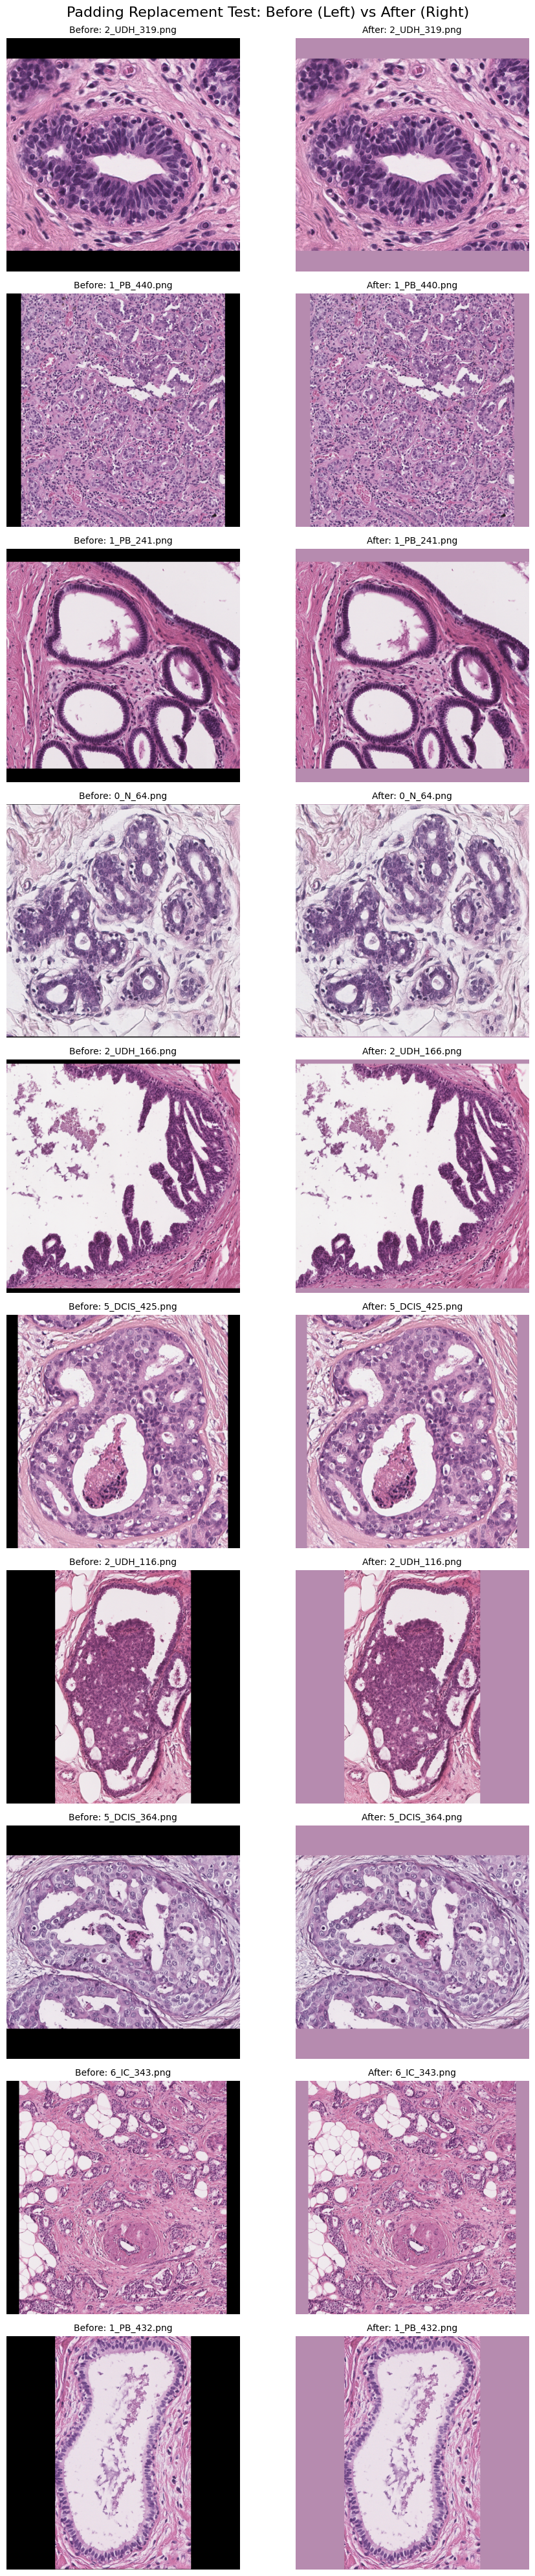


Visualization saved to: /content/padding_replacement_test.png


In [12]:
def replace_black_padding(img_array, avg_pixel_value):
    """
    Replace black pixels (0,0,0) with average pixel value
    """
    # Create a copy to avoid modifying original
    img_replaced = img_array.copy()
    
    # Find black pixels
    black_mask = img_array.sum(axis=2) == 0
    
    # Replace black pixels with average value
    img_replaced[black_mask] = avg_pixel_value
    
    return img_replaced.astype(np.uint8)

# Visualize before and after for the 10 sample images
fig, axes = plt.subplots(10, 2, figsize=(10, 40))
fig.suptitle('Padding Replacement Test: Before (Left) vs After (Right)', fontsize=16, y=0.995)

for idx, img_name in enumerate(sample_images):
    img_path = os.path.join(train_dir, img_name)
    
    # Load original image
    img = Image.open(img_path)
    img_array = np.array(img)
    
    # Apply padding replacement
    img_replaced = replace_black_padding(img_array, average_pixel_value)
    
    # Plot before
    axes[idx, 0].imshow(img_array)
    axes[idx, 0].set_title(f'Before: {img_name}', fontsize=10)
    axes[idx, 0].axis('off')
    
    # Plot after
    axes[idx, 1].imshow(img_replaced)
    axes[idx, 1].set_title(f'After: {img_name}', fontsize=10)
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.savefig('/content/padding_replacement_test.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: /content/padding_replacement_test.png")

In [ ]:
%cd content/
!ls

/content
average_pixel_value.npy  padding_replacement_test.png  test
average_pixel_value.txt  sample_data		       train


In [16]:
!git clone https://github.com/AmirBnsL/breast-cancer-unsupervised-app

Cloning into 'breast-cancer-unsupervised-app'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 21 (delta 3), reused 21 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 5.19 KiB | 5.19 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [142]:
!ls models/artifacts/akram_preprocessing/padding_replacement/


average_pixel_value.npy  average_pixel_value.txt  padding_replacement_test.png


In [135]:
!cp /content/average_pixel_value.txt /content/breast-cancer-unsupervised-app/models/artifacts/akram_preprocessing/padding_replacement/
!cp /content/average_pixel_value.npy /content/breast-cancer-unsupervised-app/models/artifacts/akram_preprocessing/padding_replacement/
!cp /content/padding_replacement_test.png /content/breast-cancer-unsupervised-app/models/artifacts/akram_preprocessing/padding_replacement/

## Summary

**Step 1 Completed:**
- Renamed all images with class prefix (e.g., `0_N_0.png`, `1_PB_5.png`)
- Performed stratified sampling: 90% train, 10% test
- Files organized in `/content/train` and `/content/test`

**Step 2 Completed:**
- Calculated average non-black pixel value across all training images
- Saved average pixel value to `/content/average_pixel_value.npy` and `.txt`
- Tested padding replacement on 10 random training images
- Visualization saved to `/content/padding_replacement_test.png`